In [122]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [91]:
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')
df["spam"] = df.yesno == "y"
df.spam = df.spam.apply(int)
df.drop(["yesno", "Unnamed: 0"], axis=1, inplace=True)


In [92]:
for i in range(6):
    for j in range(i+1, 6):
        df[df.columns[i]+'_'+df.columns[j]] = df[df.columns[i]] * df[df.columns[j]]

In [93]:
X = df.drop(["spam"],axis=1)
y = df.spam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train.values.ravel())

GradientBoostingClassifier(random_state=42)

In [95]:
round(model.score(X_test, y_test), 3)

0.865

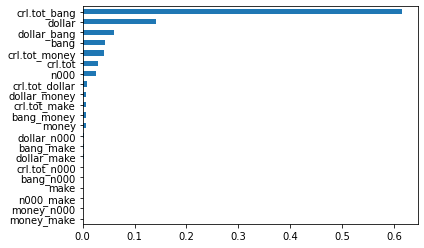

In [96]:
feat_importances_= pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending = True)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
feat_importances_.plot(kind = 'barh')
plt.show()

In [103]:
param_grid = {
    'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
    'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]
}

model = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    scoring="accuracy",
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
)
model.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500,
                                          1750]},
             scoring='accuracy')

In [106]:
round(model.best_score_, 3)

0.884

In [108]:
model.best_params_

{'learning_rate': 0.01, 'n_estimators': 1250}

In [118]:
param_grid = {
    'max_depth':list(range(5,16)), 
}
model = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.01, n_estimators=1250),
    scoring="accuracy",
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
)
model.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                  n_estimators=1250,
                                                  random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
             scoring='accuracy')

In [119]:
model.best_params_

{'max_depth': 5}

In [123]:
def AdaBoost_scratch(X,y, M=10, learning_rate=1):
    # инициалиазция служебных переменных
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    # инициализация весов
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    # цикл по длине М
    for m in range(M):   

        # обучим базовую модель и получим предсказание
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        # Маска для ошибок классификации
        incorrect = (y_predict != y)

        # Оцениваем ошибку
        #estimator_error = TODO 
        estimator_error = np.dot(sample_weight, incorrect)
        
        # Вычисляем вес нового алгоритма
        #estimator_weight =  TODO
        estimator_weight = learning_rate * np.log((1 - estimator_error) / estimator_error)

        # Получаем новые веса объектов
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        # Сохраяем результаты данной итерации
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    # Для удобства переведем в numpy.array   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Получим предсказания
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

In [124]:
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X, y, M=10, learning_rate=0.001)

Accuracy =  0.8228645946533363
